In [1]:
using DrWatson
@quickactivate "BNP2"
using Random, ProgressMeter, WeightsAndBiasLogger, MLDataUtils, BSON, Flux, Zygote
using MLToolkit.Neural, MLToolkit.DistributionsX
using Flux: Optimise
using Revise, BNP2

In [2]:
args = (
    dt          = 1f-1,
    n_trajs     = 10,
    is_noisyobs = false,
    σ_obs       = 1f-1,
)

;

In [106]:
function sim_traj(ms, qs, ps, dt, T)
    env = Space(Particle.(ms, qs, ps))
    traj = simulate(env, DiffEqSimulator(dt), T)
    return [env, traj...]
end

function sim_data(rng; T=50, n_initials=100, n_directions=100, n_speed=100, n_moving=100, n_tests_per=10)
    ms = fill(5e10, 3)
    qs = [[-1, 0], [1, 0], [0, √3]]
    ps = [[cos(π/3), -sin(π/3)], [cos(π/3),  sin(π/3)], [cos(π),  sin(π)]]
    
    trajs, trajs_test = [], []
    # Trajectories with different initial conditions
    for i in 1:n_initials+n_tests_per
        traj = sim_traj(ms, add_gaussiannoise(rng, qs, 1f-2), add_gaussiannoise(rng, ps, 1f-2), args.dt, T)
        push!(i <= n_initials ? trajs : trajs_test, traj)
    end
    # Trajectories with different initial directions
    for i in 1:n_directions+n_tests_per
        traj = sim_traj(ms, qs, ps .* (1 + rand(rng)), args.dt, T)
        push!(i <= n_directions ? trajs : trajs_test, traj)
    end
    # Trajectories with different speed
    for i in 1:n_speed+n_tests_per
        traj = sim_traj(ms, qs, rotate.(rand(rng) * π, ps), args.dt, T)
        push!(i <= n_speed ? trajs : trajs_test, traj)
    end
    # Trajectories with different moving directions
    for i in 1:n_moving+n_tests_per
        traj = sim_traj(ms, qs, ps .+ [randn(rng, 2)], args.dt, T)
        push!(i <= n_moving ? trajs : trajs_test, traj)
    end
    
    return (trajs=trajs, trajs_test=trajs_test)
end

data_raw = sim_data(MersenneTwister(1))

for traj in data_raw.trajs_test[1:10:end]
    HTML(animof(traj).to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABJA21kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAPZ2WI\nhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAO4+Whwb68chzQAABbAAZZt/OOE8Di\nJTuKp7f9/w38hZA6HbRK6Cs+DCtmkRk9YHPS2Lg5M7VdAjztImpxied8gO/mjmQz4z8Z7XwPpTsy\nkH6eoxhX7zH7BInVwpOx4fl4A0ZbpeIUno5ifWhtjEuXzre1xICheCCtKIMf1do2MQEChRgmdiLE\nJkFTCwAXs+85B+gBHY/RvUMpbasNF22jN+IraxL16y+fxgATw1KWWkJTJox+pVseb4AkhAsj6do4\neHDpDsEwQYL+3FpiUUANGAPvQvKa+lanV9HXgEmAdn0BKKMAjaDKdDe1xvkjx3s3Hgjb0c3PULhA\nkQUAZc64mEctvBsrMFfu5yi7WdGv59oqwzk6ldKY2hNgc7s+/qQCtuszmAvCP7O/zVXBw+8gZ+9w\n6ccQO0wKqvNYfE2i03YmAsp4t7/3YARNZ+8Q1a4d8rurQzCMqdis80+WEkboTUqB4eVRz/B35vu3\nc9cJ4yovmuHXYgXm7ZTfEgkx6ZyHjAvaQgXygUh08QQfZoot3nj9LWCeX+XUCGNYcFHb+9KqzWzW\no/dcFD7UOqFo0A4K8vq7vKl/akAAA3aU9KMNQLz1wAAAAwBdPGZdiK9KY8aCGWoz9ezPyueRhf+1\nRVC6BhuXp5cAz/HEn/mxqfcloyG8F7REhqtxVLJ9pU+D33IAkVCEwkd6HpI0u4g0ffJwsMZ3HvDX\nF6Y0+wIyQJT710LZ5Kf4Xf1odK0PjNvfi8or3fqtzfU796rmAo8jc4iwmAh4Y4I5UOwdsfNdY/vS\n+HrznKcOKFPIiHjNCCUUcOj8pTivhHYbPnhvNfrqttRtNy/Vcqkn+OkLwCpVnmpa9rBEPe3ozKXB\ntkMTNU4CBkMs63xabKjDbaJ/+ngsezi6NiWcf7/ECNvZ48WVWTrmEmB1dbWWW3DAyED2wYnEa/DP\nmqkg+4voLK6kbRd7AeW+wtghlovCo3gLtyufJpnS8kWjNq5avNHYXJtLvhcb97NqcjHktKvAocl8\nKLx7psn+QlAnT87CmstKRqlJ057x89HdqjuA18JrohvoRMjGloXIVqBOHx0nxrtiXRR3PBT252Tb\nd7mcqZ2DmCke+3G/tWSN2kh1lRyHh7McMrtWcFaiioq8PhlWIVlI1hxVsOltKJSFv9PYLkCuienR\n7+xaGkp5F5T15ofASmzLFG2JtFcJ2w0YswUj8QhOA0ekWdtaQj4o9Lmtvx7pagJM8LaAtZdcGqGp\nqQsMOf44GhMMOloEyqri3gDbWg5Up2ZOmeS9WrqzN9skDoxjhexnJDE+grWn7vO2suw2WFjBn5C/\nZDlApqMsABTSqyGGsg8E435S03Woxj3zwcrrTMho3awgD1NbLbQcd4+NuH6pGL8J61bc9jFVGdXf\nWaYUC3yzcud76QOJX7Z330qOtXxEIEoZBsOWj5kZ6x9Mo05MiscXeMP/Z15ic+e7jIkflDcWrEDx\neWr3I7XVUR+VVuU9pmf9kgJXQVhXpryiAzsEoRo9K0q4jnmLxilFEhJxBFeerPqA5yuZseVDwvFM\nXataLTar7nFL0AJ6aM/3HNWo+L5nz6PTfuX85RFA1r/qpiWeBEJwVOZY9XGQInN+Drj7tpY/SCve\nee0TGRNGlfXpyqgkZ/OK2CoQeqG45PtKb+5F5Tt+BG/BqrfjNEHBTySL0ym2i64VhnSR58kpvfRD\n8B4/lMi+m5WiKobwu1IF9tfo0M70Vc+0vC7arkVSfZioMPuFtRpXqSMw5CB1jephtyUCRQroMWEa\nsKR7aMaZRh5leDffCV7UXcBt2gpd6ja4kc5Dgnc2Qo6uKafwVScoxBPgxE5lW/FQu5d4ShSN1zCf\n4A2v6zISNDUSFOBZIT6u8fFbfXwsvkPoAF/ueQoSP1S/WIxHzxZvq4B8wEPeIC7iGVrQmNcG4h0I\nOMQExoPQpxx1/oSWGTxRqYzx8mu3pOSkHZOXK5VhfU2ccrhKZgp3bePhYesnFeQsdy/f7epyl1jH\noTO/gkBV7VHrxcFoOVZvS7wAyGPqRPUul+qQWGZH/AAF7Vd9l7EObWmxwCFRc9rT0xfv3XskSLQC\nZbL46hFdSmCO4eykMkqhWxpJ5wFCP+gZeXmnwatAwAJZXcwnUKgx8TR//RXEwOqHOJ9W6X+5XolZ\n4/Mw+mWfHC1hi0TSmq/ZJ4oWDG6/mA229Onq/Kyg+e/HWVUNJDKvb6Uc9+nwq2+MsBz4dWUSf8Ot\nz4DL6mctcw+u9DcyT+EojOrUujj+j+lutB4r70Mt3QpZ/u9zziiAm4YYmzX76fXiGu+rKVKoGJCz\nz/6No/L6fPpaNSYwjhpBXJO31dLkRljsHuNLy8zvsR22PSnIFCB55SvgRNs2Qiw4ELU6Qz6HswUU\nJUI8ch064rvLum6+oV82Y6cbQOkKdDfPHGwy7C08kHZOHFBS862o2nDlBmsOxKUPRAAp0HPhHVRi\noBfQaqTOiCKgBIaePR13QfLjCPNv9OngFr3sPuN3TXFwXoxd22Kr5vXBcXRfwRYyqNIcq4xoEotw\nk/Em+113zXwoU1Anzv4jIP/y2BlESAgCte8LGE/DWnEP6KzoM6wF9H6MS2MksOXKtXU3ZHu9t7DF\nCz6oMX9m28OHsYnyYyi/Oseg+06w/ZIaMRZaiy4EN76g8I3h9Z8neZJ+VQZQFs3XoKpn64M709X9\nDr1v2VlwpYiW9uP+dcN4jAGkWurMHgSA8edWrzXkU+cSp8

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA8B21kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAKLWWI\nhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAO4+Whwb68chzQAABbAAZZt/OESPzF\nAQDc9v+/3kXG2jTtX8hZA6Hbq6OtXw7r4y6BwSkKw89A81JE7XtlorEF7VC9D04OjSrBoAy/QwaD\nvIrtpyg7n1JDrcPIUvLtHSVgU3IDNZL4/RZe64FjS5OUsdkMGpHPFO6lsZ6URT8jPJK3LvKJYwDp\ntISoeLUxM3WVK+RJjNAgPppo/YZqTb7/8hW5EGltv+kPrbwPdEbgKw3N3WzEXLakaAAAAwDZFX2i\n/Yc6h4YlrQrF+SUmjdHPJ9x5IW2IPhdXTBQ89zdsESM6vzThcqJXtZx6dOYgNdm1ajA5LzjzXFUO\noaVjIrHL1ST3/ovE6P87GGT6ZRtY0khMwDJhpXiQ07lZfDnWv6+K+S5BqahOfsAZu2xVRD05Tq26\ntgAyLNZ4Vv+vBEy6sq+4MXuYIsaGGUiUKo1SrgCeV5HlMwsMfBoAM7LRJTaCZcQ6WfbVpsg/IAAA\nAwAHfmQWlZkaittLk933Or/AFoZ9b1xyPZFY3lZXdrfVReAIyAzUapFLvCFhlMFQnXOXLmdBUhy1\ndRy+vGIfpEnpRPCnnALpiIa2RgO1B0gvO7qX9bpHmnKCVKUUp/TamPOa53Q14PL2bviKUNGn6X8+\nwxbS2cGp0KVueCLrLdCl9LaMBwuvxkyEekOjCIJBVIXMROM+HglSXS0ZwbyVzdLLSjGgw5aIphkz\n01PGLDwH6ts7wQyICczRAeOdSJHyMB2/SvCdWXcmIH3AI+nn4PhcnhJc7MYEb5ieSkHWw0RZ+AIq\nK98Xq+cgwObIX0BIAAADAFWDWxSuSiE4CAAC8y6T9J9CgJbXqmYDvpCk9OM4cxGR10OddP+V/QnQ\nd0KHWp5BMu5kS21zEU5RVrTz0uR8/A1YJQVwp7MJ0aV0nQAAWCXYjOLuauUhZ3TixHvmRT8qBwPQ\n2pWz21yVBB226pDNw6Uk5zhj2qwLsuOquIqN3hwIHnbeSN+dY1n3dK5xS/alDFr+mncl+C/wknuY\n24FKCrHfTJUdl26imERy/w03djyQmzU8f1+b/FC7xfDOX4BiRO+aTGFHWmMfJnw+koBZsnq5G3C5\nVoyn6ZtE5CZhPQ2fOYmFMEDvNKUOAR1SpvWwKUzdWUfgcbYep0aKaWzBXcZofgAAAwAxwizIC4Je\nmeAAAGuYABnuKV1MsIkOh/YwZQcberYpedhnjC9vE73uKuqrl5lS6svCd7YpUGT8oMBJsrA8C38j\nj71SVE5hWmSlwAWv4tIFLAlDeyU0URT/Ovi8JnWVDTCO8Dv0gTUXWttqsRRv08easV+LS6mtoSyH\n9B/LU3GqwbiDU7lrPNGBwBcN0GkdBe4dj+hvnSIJfXi0XaxY2ubxlUNjbKzxCdSVLguV4UFHnFZk\ngWr/YuZbODQIQH3oQ8QdjrDkydj6uAqXQIYt1w4PDywU9oyTrrjv3TZjIYmPJe+65XUaiLnsnm8J\nPl3Yc1Sc1XOxX/mwjMWAFjH64Eii/qG0M+UcpjiMDgG3OlQYoYnRcEQU2OnQVEa7mkzIp9gdGCG5\nc0/M/ChIM3Ue2epRBOewiDLeWMzh9O1/siJ3nYA/nUd+LC7JKH3hojDbZIMr8A+6PtomAxrMuqEJ\nyVYnGyoQ7Hr/1v5fMjJo28xCGq4K1jY2JK0Czmnzvid3Trk4s4OmCSH/t6DAAAAGKkMkwAKwjAAA\nj5U9fpd6fUccmH8mi1EblRWcbmzAIN0BO8T1WyEcoKavL76E+Lzt4k3jIJTfvSgPZjpyMWzFpSlY\nWBag6xejTaBCP6aBq0ZMTG86NJhX8vBgkg9VKljjTO/92iJPuPnEtKAMbLnObO2Fm2AzFltAVopJ\nzslxxfjPJU7aSeI1UhwnC5/RhAfyqNktFrVCMB44wTTrrvd0TcVbXXfSWB6eskxf2b2y+9jPyp6e\n8PX8Zr4tPZHbxix0aOoTzX/NkwhdsynwP+MqiTYR5bol4ceIkzrBUwa7nw7cv1aqX6goDFAAAASM\nEnQkSU4gARddVG5u5Hz+Pg4yIgGzch+qL6/e/IcS8RjijxShCSEnjfsBwCaAYNHN3iU+JsyFs+Hy\ntPYp9jSEwZt2NzH7uRsaI/khtQT1GZ0AkXldO0M9fxElgp4Gi5IK4aAETcfXIym+w989qEbP8hLW\n7Ra3bM06ntKD2Wjndu3NaxQWpMvc9RSqRkvLewcfA380i+lPXUEP9eqVft3r+zUjSR7WmkLOSK79\n3ldKOxWye7c/HwAEbFNP77dpqyGdPc5IAdWjUuPqewFf/rsqoUkxj04DZV4ygdsIcXFtrYwEcGLC\nU/o+nJSpufnGfmjUlFcAAAMAEMuGGFafjgMTUPxnE+vHXRKtLRdJ1l0EaHzArER4y1/7zunx14As\nUjTQ4NXJZR90BBwjCUYjXFp4EI0yw0iaWKNSaDe1BqNxrQJ3V3HtGq4ziH/wK91bikfZ4lusnlXB\ndHq/HEV5362lWUG1lq7BXW0W+sNhA+jJLL1qaAkTSlgg+gvWwEQ7DXPuAQe5/IasBax+3Q6oA9M+\nS78ddMYb155bKbfZXiuApRM64JYDAbUodKhweqZvpv+C86//UfNIGs8gV0kLvAwr+jQo3zKHqz2T\nULKwGsM9jDOKR4n7gBFvV88uYlOjcJVz0CvCBvgdL8aYd7cUNEd6x3IHGouXWf2TSJGuQAzVv5Dt\neylzo5fhgpPsHKztiUTTPjA0JtlnwXtNwzxWiePLPdYoj0

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA1lW1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANuWWI\nhAA7//73Tr8Cm0WXagOSVwr2yqQmWblSawHypgAAAwAAAwAEyF+F1hnJSk2EAAAd4AHePH5wiR/A\nJqU0M9XIBiZ5FmtL1fno7HDI+Uznm2J0rBuIrqfBJW7xEBBgsa1ABl2h96t4Jsm+Al32KjqZb2A6\nnCyCngcUrnE9qUOjIOC1g87MAx3PZMvcpcWIBBxeqQBBK2DV5eMyAVaHpOOu37flPeNmY5VbwsPE\neAKVK4zgTmjupSyq9OO73uBxPDKLEva2FGq2x3EwvdZVwB0QvfRLSkAB2OPFQvdgBH++DYG8VvcK\ne3WYvep4HaF0yvQTJgFSaFHcEIFQEWN3vL5sItrD4jtveltHx0mm8NAkT9/FsDVZHgFCDrpCULgH\nABngWEADMX4EDhnkQfguJMkh4OQDeXEKnHuBs2GmTvnOrKLU7It48SaAdvp/1WuS/OS9fj/dt//y\n2h5Kp1GeDX6En7ziNQjA5/LQ0PVTApdWz+H6GIGzjew7NZ7PsET6eiaYfx3apUF7Pe30p9kkX7Rb\n/l5RSUW9265YdW3WEkf5Ut1XEbq1AFipDBuW+i5I6KoS64rJ1+3exx8sVg0H8yksAAADAAng3X6G\nBYuJHwKf4SMCEkBkbJEu/RI3cS+xc3dB+K0OkEJppyBtiF/b0Em98H9XjckZJGH3tLOJapQ+M0fY\n8d8ia4+G1bK4nwC2Fw9oGuzipeQ408426uMJzU3O/C5L1ST3/ouZ1nNq/6r19uSKyVKDlk1r+YFl\nQM+twUrum4Yki5t7o8+Q3dTF/+OxYTLvb+l3puDSny1RCTmm26XvsnAFuEXOK4+cK2c/+9acERaH\nD11fUaPMcBsbvlmGzkL6Q37nwla/cUawphnl1YGcwAACMgDSaym2Ag19zGO9M9BPCXo+EQx3vOZz\nDTRC9l15mQW6PCiR01FPXtOfiJYcAkTWSEb0s5hiS+xheqngNgyGIP1YpqiykxYsnrLyFMh3gA7q\n0eawWnlN+v47aKUy6ooxisQgsaPYHXIP/t+oUu9B97g/+1AQlNlV4di5y4jg28gSO5sxr58GcQPs\n/wsBmxka7FAzgAKWT0sng4yPICUqRjD2PQYFGwDfgTbbMxDVsXALKBg8WvVJ+T7o+a+HYyjymlcX\ncqbc0GwY5BXAzImRpMNYoJW7zukMm7PFlXCbxrQwG3ltEAaUSjDC94fK72haM+Yv9WMHCkl5IlV6\nlRTD1us7UkkuEE5mBPOe5j7OdsV47zz6Yht3S5CtJ5ggfk00CCpKCOx7fM4n73dMtS9VwmpO8Q7r\nZoA2zDTSVScwkPpR5wTdHI3MuzwYuPkKR0AcT3R45nMJO27dh51/hOTkDutCAKG8okuKAK2MaXqc\n70umdfJ2g/lG8wC8dsk4zUi8z1i7GBxjkW3MGBxpy3L/gOl87aLLq6tzqkz5XOhwTDk82Mhjrgdd\n1BrM77idH2JKRqMADf5kkqfIO/cv1XxdhfN3fjR9ddsY6XJx40zEo3FBFng4SPtZiwEiDfDagRpk\nw+gJ81GK092fT6fqB7EU5F8lJyBDgD3oFb/1xh4LV/EwiXLkdt8+S9KhrNfP8DrIB6XrVvc3NMGk\nfV0YWq0l4AAfNmlh51o0CMR11wZu9+uFwGGOmMsw19vaWZwqjd7VHDAAE0jsNO4Mj/Ty/S0na/D4\n70IdH7u6xEf7Vqvz/NoG0PvBlebQM31qv4C5qMpLw+yutNtsmAF/Q1cTejsBknq7jj58iiPUMZh2\n4nR+mwFfb5L9K5dOTL99HxW1CGPN5KvP4ry4Q6m1n5pESIqiH4JlPer/m8NmY0jf9FlUhNN8Jg5/\nYpb7rJ16sedrdbXd9ZZ7txHL5jhcQ/e//8Qm4sn7t8uPS7rpZYQAIVVvUhTh8gMvJKhaH4NIHms1\n7kzWbY3vxquipfhrw5Wa4Cmz9EUBpt5vbC4v9aiEBnugzOIgQzxxqTwVXKXsWvGK1e6pD5/naJnC\njmewF35lQfTvNcIiGDeoqf/+u60AhlHV+OJeinmjy+Mp82Cv5KC7RSUBJxQ0ezHIXWozYHY5potF\n8WLUlhMpgFZxEGy//uK8w2sO0rqMISanotz3SvePQyOybTp0WaluOGwQUcJ8gLKCMZWbq8BIVI6t\nswyhyvP1gH6ZVTLU8u0LAJFe5DlB/ps6yu3u22xp5kD86uPq5KPh4z8aDiBK9Yb2CfJSt5ALv935\nD7ZWufx2MDuWabOKhBskKfnwHiotnBRxNC4cSh/vpBsAAAMAAG9msny289M1NGdTT8JndXR08iCu\nA2iYl7X37EU6REa0pv7oqp7+YPOpCDnWtSUwSByp0hTOWNJNDe2139Yya1+d9c+VCMPI7DD0x37n\nSGVbNTNJZZZQp05jSJi+eCA1lA5QYkmg7LmlzGzAcyYB+YtatFjhsQu9u/IbKDUBFm9CiGLj7amv\nlOhNu/05Dx6D5IDLA8XIS8uy3E187tODLWsd6TsmmTg5gmRMrALOa/KWI2XoZ5UnSpXjrVP8K3Fy\nJySmqsY0nOM8RLRpbe+TDKjzd7Fyv4FF7bnmG9wbcbizWd1rZtpP4hY0MngQGVAAAAMAAAMAE3o6\nYP2sz9mvMxgJBERR85e0C7CMuQ3KOJHG1Gy3JCdXD3ak4c0hcYPN2hC6M/ID//RRrymXlVgnf5N9\nFSdp3QJ4jm5o8roPo8EThRLxlrAiARTT/y9q5KFuTik4pGlA//3me2laHb0bXseCA8U2bFkYe+mm\nVUP8/NZE7iA04ncTcmt08UYHBIJS9cUD/oD8f5AWVREt7g

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACNLW1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAJbWWI\nhAAr//72c3wKa0czlS4Fdvds6GkMSjhe5UuWLggAAAMAAAMALD030J5B5ct0wAAA7QAT83OLZh+g\nCOKV1ufUORV5smh3WaBV/esTASuI16deUsV2gXl7TJPtz/L3RuKsOgoNpLhETuQpi/43Vic9ENfL\nfbShvK3gjXKtUTtMIen1AXSBfaoo+9V5RieDBbpEZ2Nagy0jI6U3umFAOCwqn62E/JgTobNuviwY\nhKVPjXvJXtCEuM4vYrbSYqANoi0DC4fBmlMnM4qAAACd11dTn0BG+FVp1IucXavJCOktBtJn7zu0\nErM64dL5UYY85rWIyM660/KLwX6CJAsuoamj6J1R4P9K8C0L3ViZZGS2dH+BmYSktSb1fJW4FvQV\nHTzHVrW+tGYna8Gpwtj/meyxKWUZ2L2B5xfuf8A6oAvywW8XFX84RSlvGWFwePtvBE86lTc6dQxJ\n+lQX8Zap+qdun6AKABdMoSWPVuix1vRj1vMdsBgteKWz7f2dkRXo0mPsNVokY9XCBUJ1sv0bRn4D\npGabN4VEJh9X1FlODX1SLLEL+1sZEpd4usgCEyBDIJA1t5FxB0YQiFUITDmjOm1GN2Tgb2enJg9S\nFLz6EdB4W5xpiQ+hq+4Mqk3+yqw4REeb3M+nMLnyMmTTctGEPL1hFWmZHzZtscPeM6OM98FgBfqc\nAL5TtqXpOITq5RdxJ2ABdFBTA9JifI0/6T7q2Uy7av0GoQMGGmTqC8Yxr5/pQRi4sJ+NIU7bt5Km\nSAmOqXzfDlhtKjntviA/yTeVuhQcMWbhokAEQHUGBxeYr4i3lvqYDmSCoknUdrHt1fwRTdN8tIGp\nyh0H7SCC/Hh1BC4MAkZhSC5SF4dyYu8tXUsM2YxwECd3fTwXMBSPXrv6Eu+aFIfncBRL+6/LFu9l\n0peIGcelc+0/CLAKETdoFuYXQlNWCkPOucSgYJL5sDJqw5guPUtxQckoNDX+H+0MCsaUqGSGRxoi\n7ISJzor2mcBRC5OIuRxDb41gh8QxOy211NyqBrwd8/FMWN7xk9zro7mHd2V4Bjgr/cOk0S2VXhAt\ngolDANVj+c4Mu4QWmgAqoYmoDd7CFJHU4CIFcBa1TU9lRJ4UKMTNudedPnYYbMZyY7v/lP7/9aWU\n8NHo3TKlHogdjJeISgooGuIlrbs948tpZILyYhAMc1AclboRv+PpYsIrwGog7EbCeXPhTJ/re6Vs\n4URWze+DzqwiyRzpYFSbzI4lljDGExC+odm4bFBaavbmCZZWp+b3FtsBbHAM9ronb+ksA82x49Zr\nK8rZmZdzTLvj5c6+9WPcm8srkSw0W3tv6HwotUOnEtt1pK8rSRrRH6owjdss0OOBhvlBZG+zrS/D\nEqkd3XK5ICgmo115Z88byO6UxnMIZaWVjT9/HNsHoObo66v8RaRDOblJffCBMOUP0m/m9+Pg9O5o\n+p277yHRMzfJDGa6b8n5PHlm8WfD7c8kUtDycO/ZCy7eewhy90BPUZqbpt4Avkn+M2RKci6eGcmR\nSm6hWUq3LMRx5YHWyXU7rfyGmEp0cAOISxzECOZYsy26+h+NS54n1ycfMDlSOCKiDR1E+FdsBqHf\nwCaLR5+j2PLI7etfhdWPAPFvjT2IOu0uEEVIBjCscPq3hBcxAPg174+zQsAbz2isdkExTvU2Oy/p\nX27sfXJvpNfYqgYEgXLMwVfugnLrAXaU9ohY3gwsYHj4clkTKC9+Ol2nR+/sIgELIkEnCszuErkR\nxp9cZj3y5FT88wLD1NiFeibGI16B44QAgCwXrcsKHwo5f8ZRsl1p81H5lLQlFvQakMW3ZJbfxvFp\nC6skxncTKynRJuvVzDsv1vcu9RXgmkV/VWRsXtrgxIuNSNFB29QeAQBcOxLHCoE5D6MFRDt07tp0\n/tUMU58X3AR/tD/Hnn47LV1kPowgnVxYaekrpIFXdniKWcc/YqDZ63zkZeAv/wlNWWgVEeq+nBwC\n0n/fS1if+e+bkeAPOY1aM8TxyjPKfJsat0+pswYbmBp0z1wjwuDIYjCmKI9WahT4vidUqDKEe3cG\ndvu6dllJHHNcsUhjILLcAFpggDXgSwxAxV9nixzXNoMfFtu0drrE5k4drJGXtWujB7ihAr7ZFkIV\nynp2D1FWk1GRO/jCaaCiAo5vM/I/SjLcFSJPhkDke7xgVh25Dv6FLUhwrQlL/DclxDpyBZ9lSxCB\nj5rGn9MbAqfsXRHNMEfp4qMZcX7rW4LzyrUwfB1e+DRqBwd47wzhoc0tGoNcAt7NnOq5KHZ4GuTr\nmC/Yh79/VS35fvxeZlM0j8k5G9JRbWCGuWFnEDct3WiB7A8+XiesWKMedP1s1a27DsWoBPhLFw3Q\n/w34x7WcPvdDN2QOyrt9jEVXD7qnt9yS5QOETCMGtKIehDk1R2BAi03JJXram92K8OHWapkfQQal\nMIo3GkY58vmVsPs8K2aIvwxMFGOmhv75nNtC6e/+6M3lA+CIW8/bosPu3xyg9PlX4v7ggFqvEAPl\nBHdj1PuyBaVDKTlOqOzjV9oFD6hXk03QxZ4agfc9hhMFC53s6efst58CwEyBCP/xi4hFxpbU1e2K\n3cX7LI8JhU5J2Q4GO1WIMH/7xh3VfA4ntyWzoBgww6vK3nO/1JZ0Z4JNEMwytWg7CrWAjDilB39b\nyx+j3dcHVwc4ITAX1BFQPxAtVNfw1StCdDEhdb7EaTL3JqDPqdt9xF4shZGTz8eyVoT5ZGL+ajVz\nudzauhGcX2sJImw1zKDbaxUgt1a9/OFcJMSAiam2KxW3z7

In [4]:
function preprocess(trajs; n=3, d=2, do_shuffle=true)
    # Convert trajectories to training pairs
    s_list, s′_list = [], []
    for traj in trajs
        states = stateof.(traj)  # Vec{Mat{n * d, 2}}{T}
        states = map(states) do x
            cat([vec(x[d*i-1:d*i,:]) for i in 1:n]...; dims=2)
        end
        states = cat(states...; dims=3) # Mat{2d, n, T}
        # Add Gaussian noise
        args.is_noisyobs && (states = states + args.σ_obs * randn(size(states)))
        # Create pairs of x_{t} -> x_{t+1}
        s, s′ = states[:,:,1:end-1], states[:,:,2:end]
        push!.((s_list, s′_list), (s, s′))
    end
    # Mat(2d, n, T, N)
    s, s′ = Array{Float32,4}(cat(s_list...; dims=4)), Array{Float32,4}(cat(s′_list...; dims=4))
    return (s=s, s′=s′)
end

data = (train=preprocess(data_raw.trajs), test=preprocess(data_raw.trajs_test))

@info "Processed data" length(data_raw.trajs) length(data_raw.trajs_test) size(data.train.s) size(data.test.s)

;

┌ Info: Processed data
│   length(data_raw.trajs) = 400
│   length(data_raw.trajs_test) = 40
│   size(data.train.s) = (4, 3, 50, 400)
│   size(data.test.s) = (4, 3, 50, 40)
└ @ Main In[4]:23


(loss = 42.9004f0, loglikelihood = -42.9004f0)

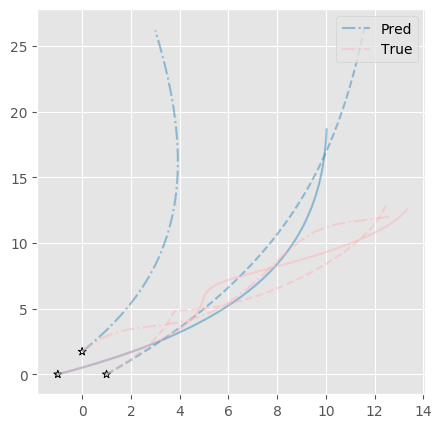

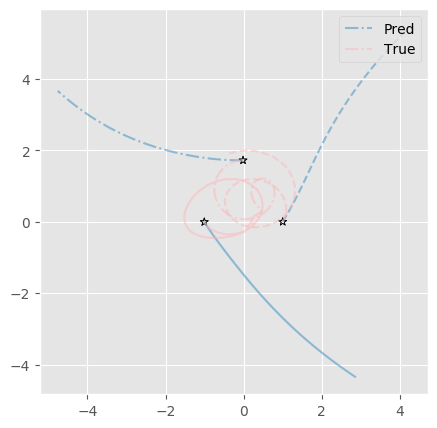

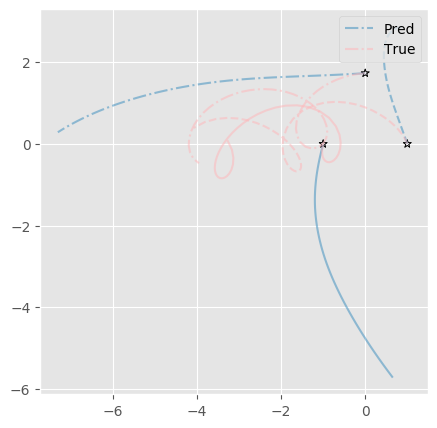

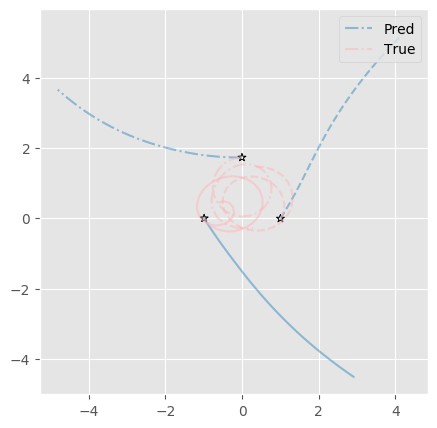

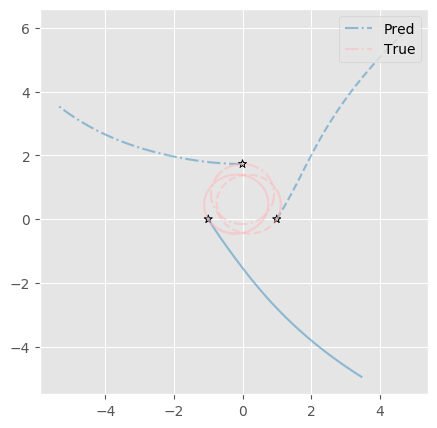

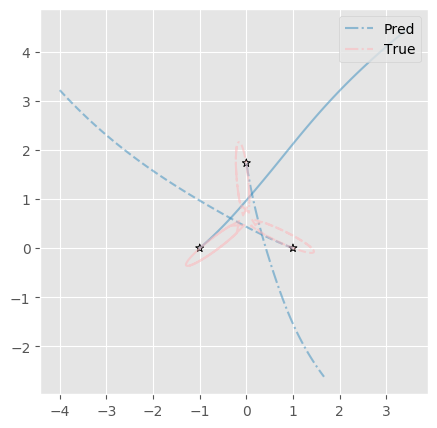

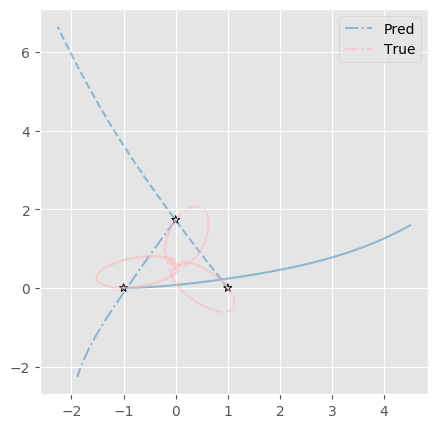

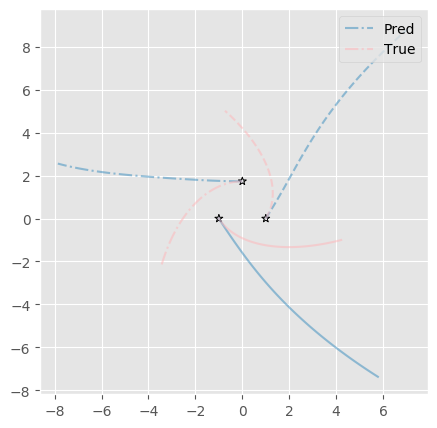

┌ Info: Main.Models.NeuralRelation{DenseNet,DenseNet,Float32,Array{Float32,1}}(DenseNet(Chain(Dense(4, 100), #30, Dense(100, 100), #30, Dense(100, 50))), DenseNet(Chain(Dense(100, 100), #30, Dense(100, 100), #30, Dense(100, 2))), 0.1f0, Float32[0.1])
└ @ Main In[121]:66


In [121]:
include(srcdir("Models.jl"))
import .Models
Zygote.refresh()

function predict(m::Models.DeepTransition, env, T)
    function envfrom(state)
        dim = div(size(state, 1), 2)
        return Space(Particle.(fill(5e10, 3), state[1:dim], state[dim+1:end]))
    end
    state = Vector{Float32}(vec(stateof(env)))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function predict(m, env, T; d=2, n=3)
    function envfrom(state)
        return Space(Particle.(fill(5e10, n), [state[1:d,i] for i in 1:n], [state[d+1:2d,i] for i in 1:n]))
    end
    s = stateof(env)
    state = Matrix{Float32}(cat([vec(s[d*i-1:d*i,:]) for i in 1:n]...; dims=2))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function plot_traj!(ax, traj, is_ref=false)
    local handler
    c = is_ref ? COLORS[:pink] : COLORS[:blue]
    ps = positionof.(traj)
    Q = hcat(ps...)
    for (i, ls) in zip(1:div(size(Q, 1), 2), ["-", "--", "-."])
        handler = plot!(
            ax, TwoDimPath(Q[2i-1,:], Q[2i,:]), ls; 
            c=c, alpha=0.5, first=(color="black", marker="*")
        )
    end
    return handler
end

function vis(m, trajs, T_ext::Int=0)
    info = Dict()
    for (i, traj) in enumerate(trajs)
        traj_pred = predict(m, first(traj), length(traj) + T_ext - 1)
        
        fig, ax = figure(figsize=(5, 5))
        h1, = plot_traj!(ax, traj_pred)
        h2, = plot_traj!(ax, traj, true)
        ax.legend([h1, h2], ["Pred", "True"], loc="upper right")
        
        info[Symbol("trajs[$i]")] = fig
    end
    return info
end

# model = Models.DeepTransition((100, 100, 100), args.σ_obs)
# model = Models.NeuralForce((100, 100, 100), args.dt, args.σ_obs)
# model = Models.NeuralBodyForce((100, 100), 50, args.dt, args.σ_obs)
model = Models.NeuralRelation((100, 100), 50, args.dt, args.σ_obs)
@info model

using Test

function test_estforce(model)
    x1 = rand(2 * 2, 1, 5)
    x2 = rand(2 * 2, 1, 5)
    x3 = x1
    x = cat(x1, x2, x3; dims=2)
    f = Models.estforce(model, x)
    @test f[:,1,:] == f[:,3,:]
end

let model=model, batch=data.train[:,1:10]
    test_estforce(model)
#     @code_warntype model(batch...)
    model(batch...) |> display
    gradient(params(model)) do
        model(batch...).loss
    end
    
    info = vis(model, data_raw.trajs_test[1:5:end])
    for fig in values(info)
        display(fig)
    end
end

;

In [122]:
logger = WBLogger(project=projectname(), notes="")
config!(logger, args)


wandb: Waiting for W&B process to finish, PID 5032
wandb: Program ended successfully.
wandb: Run summary:
wandb:                 _step 13077
wandb:            _timestamp 1583773403.3263867
wandb:   train/loglikelihood 0.47955235838890076
wandb:            train/loss -0.47955235838890076
wandb:              _runtime 48882.116632938385
wandb:            valid/loss -7.3079142570495605
wandb:   valid/loglikelihood 7.3079142570495605
wandb: Syncing 8 W&B file(s) and 2544 media file(s)
wandb:                                                                                
wandb: Synced woven-sky-102: https://app.wandb.ai/xukai92/BNP2/runs/7dekbt66
wandb: Tracking run with wandb version 0.8.29
wandb: Run data is saved locally in wandb/run-20200309_172847-3ugkrjtw
wandb: Syncing run ethereal-plasma-103
wandb: ⭐️ View project at https://app.wandb.ai/xukai92/BNP2
wandb: 🚀 View run at https://app.wandb.ai/xukai92/BNP2/runs/3ugkrjtw
wandb: Run `wandb off` to turn off syncing.



In [ ]:
let model=model, ps=params(model), n_epochs=200, opt=Optimise.ADAM(5f-4), batch_size=10
    with(logger) do
        @showprogress for epoch in 1:n_epochs
            train_shuffled = shuffle(data.train)
            for (iter, batch) in enumerate(eachbatch(values(train_shuffled); size=batch_size))
                local info
                gs = gradient(ps) do
                    info = model(batch...)
                    info.loss
                end
                @info "train" info...
                Optimise.update!(opt, ps, gs)
            end
            @info "valid" model(data.test...)... vis(model, data_raw.trajs_test[1:5:end])...
        end
    end
    
    bson(datadir("$(split(string(typeof(model).name), ".")[end]).bson"), model=model)
end

;

Progress:  40%|████████████████▋                        |  ETA: 0:07:39

In [41]:
let model=model, traj_true=data_raw.trajs_test[31], T=length(traj_true)-1, T_ext=20
    traj = predict(model, first(traj_true), T + T_ext)
    HTML(animof(traj).to_html5_video()) |> display
    traj_combined = [Space([objectsof(traj[t])..., objectsof(traj_true[t])...]) for t in 1:T+1]
    HTML(animof(traj_combined; refs=[4, 5, 6]).to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABl+m1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAKzGWI\nhAAr//72c3wKa0czlNd//6f+V4UG4IyTGBBQUQAAAwAAAwJR8AAAquCK3fG+f4n0ftkNzPud75RG\nPraTSSBVMo+v/JKAxiwv8lbK+iyR3gJ/wK1eAt+yC3cbte+MMQ/YyIZyEku/fy8kX9AvQjCPTp+c\nsQMwycFS1ejV6abQYTmzcrEFODZ5QxtoSwY3yKqmwdEOhIhu3tHy6FrEIDxMDsgIFYIGCCgmMwqb\nOS8PMv3gBa4T0/uZCv2RDAFABDoElBURNiOHM4K8MNNwgL9WQoFu2yLp3g9lYDkRhbwcJgrGOleG\ndnqlsfRmuNTDlCdFMkXhhawYaaS6XlXFPYr/v1uFc6upJCr6Air0m6qaYrKBWe3jBx0ISK85P01e\npstdSQPEW0YCWTwo8hS82x/I2WPhaDrDufin2G69XPn4+bS8xd1iglvA5ExmZY2SbElto5MBFXcA\nJg3m3JygYYujh4sF9b0fasXH/8fuiME0+6egG1P51OuiORaLkjS5Diio7WJk0GnucmXiuFhwBFEa\noXMCN5Wqm6c5ojNhO77mjJS1AM6Y8jWup8jz6SraMo0nflCccJCmkHgyj9Y91hykwCxkSkauCE0C\nSycTfJz3iXkLsVX3mluDmd6oPCEZP0S3VS6QK6wNsiT29mYF6IiMK5SA7m5VgBESgZGyZ9PP2Tuv\nOFveLi9OutWo5Aa64tv9RpGAQBReii25SrfYMHRENtYrBVhMWJ9r95hroLbmup6YMoBWsKe09+HC\nEQvPoFmagBekGiYnNRkU5afUHbA9HwyffGxaDIci4NRnDD54Oir3zD5YY81kyRGt1jWgseQjRDPK\nWaJac7L7K848SqKq9qkXPT60S8pkJ86aDr1+YEVAR6/H25DSOE1UyGOvFrn3/OcBM5b6OYf+GLnv\nyiBkvjzeOnCls9v2cpKR/VGZ6WIvre697GvrPcOn7aLaKFYMj+Jj+v2Mt/M7w4Pld7+SoniGGR50\nZbhYAf3ptchjeCB9PxOaSGaQOnNf5ON69M1XnygJzOp8xxNyuNfYLYbgMRrWJ7A1Mne3Naget5IK\nM3UML5LxU2eR4PAGWMwUpFFujseGyouNYXgOn+RP/9yqMoyVoOrEhDbO7yb6wUwiX+DX04X6SqnZ\nfF2nh8fYrxm5jM9rWDfjHByNQnP6zLpjgtAXFN1L15rFK2Fat5sRpcFI5ulud0VNiUUfmyXC7b+m\nVTaUlezm8ap8wQrDLd59U9XNIUT+vHbpCT21ttXA13nkFqWQaZYJjopTO2icDWN0JnQhSIfT5nwn\nIOaMoE4mxQk9+pY6iBZACWrXD0sJcLHANMVEhdG9S6yJr3gIFbtcaSzle+z/oUbeiEx25WPCObtc\neJKQj0GrXzszgqMGfayqMSg5BCoF94XGwCpAspDEDYlByTReuRY2ec/cb67HNLfR2VIkXHw75VQn\nmhsPZk5B4Iia80G+U7Rfs/bjuj4EglsnyjeCY+vkoA1sHxe/t8d2BAf8gMReAuo31vo3mASLFE8S\nwj2StwhgR6j68g7nlNcLvqdzIkHNLcPEXc/TJPJ7REiLP3fXq+2TlDjxKho9XKfYa6fZRJEIOODA\nx/C9/Ao69p8gH9hdCuwaW6a2kkeO4JtPw0ISmhCXR17w1SlS2vWNCflYj18QAjTNxxCt1MZ2bC1F\nVfECFXiUOhMiNR1u9NnYyWDTEVICIto8nQYw98W+A/2t63A2Kxi4Mj/VHF+rgtdYaawvTTBIR4qr\nzgoPYzm5Ayn8sYaSfBLIN/W/qjqPTQWdmRjVmMQNGZnBUbNcTlih9Pesjbo4zuCE3IeICoAlfyWO\nxwnM3nfZFsxRseGIaLbRgy0SRI9uSbYaMvvV22bZMJvKkaC7DXHUT4RDIByxThWhRhPi16EJFFXQ\n5s/a2MNiCbjWoBvdTYugmtp62V9SuUoD/g6AdXFngToVCWBwAaW5iIkWPgoMGqC2MhDOYlUoHypg\nvDI/OcvxvStWZhlbIVRi3NLxwEjT5q0moKxs3n3RdaU2PMeYfVIMzQ0xDRk3NOpVBOdgE+UyHvZw\nxoFp9/xpRY7+xs3oiY2Dp/z8hQ6fWJ0AfnVPrBTyHdoOHKcDdJxIgBU/jSQVv7UAzBPYjHMxepUW\nbtf6bxLiVUInCQJ9qyposzYOeEL3FMXiarc4b22kKXNiMF5IQmsLTpCAAALyJjXMBGd+nRuODgrX\nOsUSLgdvrRJTvbNKUxl1Pr3gVy0744wDseZyf35wCDFYB1IpIIROAY7owOIJpBh95mom7ZM+86WV\nL65Q7U+bWg+kItXJ2iM0gEeL1A6Kyg4ZcUTKmmpHGOGT4UpEuQ7ZqK5X/qotCSxMAk8KbU/z1Wfg\nKDaO71hTxTapMtbqOiBJxTR1sFYkoq5Hmp64CGSQ7+PJFJxzVIV/wlqkhf4dyc5ddqBijnpxy5Yz\nsQuBR66x3RjJBZXy17IcE8RlhJ3HELgAAAMAKail3eY5TaXeQSaG3E6pj8LX7+tMqmAzZVHHseSU\nP3NBPAOIsbwgMsATi3fZ9Il4nJlFE1jBEjd7hXMSGtUNWm/AEP3HMrxsxkiQhNmtHJZfcj+JaaSc\na0PpP7xKQLbfZkuMUmrskOx3LeRiMOUPmviBFQOyw11aMygBy1jp84Ld0eYrJoen0KPFR/C4pNw0\n1i47XS5m7LSxMERqDpkd0e0O3P2e2U+iVVvyiaUvyNzliCrsb8NkaQI14zON6AdelT6LKQDM2pOh\n9yvaJYL5pLeEhe5ofAVSnGACI8OoJf05W+bm9HtPl+sa60

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACP3W1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAM3GWI\nhAAz//727L4FNf2f0JcRLMXaSnA+KqSAgHc0wAAAAwAAAwAk5xzESl9th2YAAAMBRAAahr/LESPz\nCce+mOYjEKWck1xA1QYchDP1iYSpdRpoWv5nV2jbe/4/K8NYwX0qFHyRDQlit53mVLraz9USoUsD\nNiu9pWPj2PpMRWhSPBJeSEN3suyVyr9+jGtrOtUJMx1xhe4OyqG46ypjw49jheXgAAAqh/WS75s4\n+/VnuEjHDO6I69osUPiE9WWkVxrLNIVUZv4tlFG0kFHFShgFvTamIq2/P3bvImtVudqTR6UrPpP7\nd04gvYgKgoRYvFeUHX/g2N8icEGbsJWMefsodQVAnh+Sz1ybtNj1rjdcmAKo038cIHhLYS4/SUYB\nlAg9kJJ9qyxNnC4kOyelaiMkQI+LOzruoNdsqUv4gJ1Krovr01YodAgRrX4Gf7ISZIrOYTYoVGzx\nUXgZ+3OivOjmDvZxl23FnGvQhziARr2t4sgAAbsb1qGwAABQ1drxA9+Jb8CJg7YS+oDMSjNKL4b4\nLNrwboqXD2lS77crsaSyAXch1oKDu5ls/TH86tpH1hTy//VFN69YaREx6jNoZzmKm2hWX/OVzZRh\nXafJ10Gdwm4I+nG7bznjUg+aSBuAHyegIXPEnfQ2t6Ea91dpUD3aXIERDb4QvlNDYQtwMAWoye2w\n0TNe8jciotMcOWi/rtOaGK1Jwijp1F7eg7f74xY0DrCSL5yOUhXZ/bxbNy1452kmD6/bekX0s62V\nWYY1u6VLxfsKU5M756g9uAwS0gIE8bYjtFck7yWPfdGK9bFUaPHkrDogDzM7xydmwITdUf+PTAza\nLGBNeFsU/+bDQbR0yrDy2ibcFll3vaaoCHG8aWrISD/8NqDrs/g30OxCIGvGVKYlkq27IA0CqckL\ntASdmkvYEmDppc2///7jG8vVcN+xUxilWpoBbjpjQJQsLh3Vj71PqJT1aohYC6SfA58B850jhIPU\n8/WGo7fXe8NLWLGBiBtJ7i3ZziMP8zntKDeXJA054iOMtozA/JVLCxDN83jxSqqjTlUnD8T7Lutx\nFqttL1FNtYYikLH4Ii3JWalo78PABuipuY4WL2MfJG173rYerUguq2EtAWi00WokoEnx4/H0+eYi\nDFVtos3OV3qamMAF8AjnRH1GQFT7qvwzKqmKzUZ7NBhVscr6YVNmKGc0nSm7Dpiq8g9wJ+lIbbKQ\nnRh/ZdA/903MYVeLAvdCCFnzaqJOLTxf6jA88MCBaGVCBTjVXkWB1ZtPoXepIiMl9ZS3hbF+Opou\n6XLdhpHE1Mx0yNhHWlgOWDuaKaIP/hssJKWXza219ABgD928wUj/oDe2pCma+1+sONGONnxKihRd\nXbPSX5CvxWwTF7X//+Jp/7hNgUMo09nCizgYVj5+yzhMvOfUXMYqZZFLCnf2G3TCJ+8h2R1HDxlM\nZzSLNYKtI2RJbk+IrbqCwLYjREHeQbj363uxRomkppyzxQAs9WF4W4PlOcKpeu8ipSwQsbERSZov\nlgPE7/Au12YCo0mE/mtTaLhYaJDylWQc/flILEhSe0HbthurnSO7v0QvNUoRQPWESSojvevUD2tI\n4eWi2nPHiKElse0kkKwYwSuABEwTgPpt4R8Ot7jGC5tj8XTVS7l3BxnSUFhnGv501fnS2EIqQNoL\nXr7hrcHuY76M9/W/6SoiEcWzJdoV2oGOvKM8IZBpSKd7m4wWB4OKNpXVwKdO23J8FScR4R7EdVEj\ns1BSRGG4srv1PL7/CsyJnvWFYtyFk+aq8Qxv53s/6hr3JsUU7N95h6MBFJoYfLQHQBzRtgZn0is8\nQSZpe9Mkd5IYDKQrHndW1O2Brr6KNjyR5WlE8OcdnQgijPw9FxRjofndeJI+6tv+igRm/7iGJkML\nKDzXKe5vXBtaefkT7c6zLiW6IvSR/DFFHwRRCYKv6CVmLIGlZBr3ZdcMoUnkWA2PBiG2Lbz4FJ+M\n9lT5oHBvSbxoW092dZiIcN2pnJJaJzRqJ0N1nDeM7CKak+Ze47CTiEkqDBowrIA67aQNJjkBoi4V\ny89khy2ON+i/GHXT/e5aPrtWk6RH70DbBLBG0Hfy94B7WMGtiuyw8ZPOcXe06VyGv73n7Tlbw128\nN0yLT3049fR/TUE6rRRxk1PmeJFDxcQQKuLG87CFd7SQgOS/Wk+QTpDIotyo6dhPO/I0XhMgPmVz\nN99FeqG2+I1nXnQAJGU466goG69MmG9BmWG7De+dlFP/K42zphb4b5dv2YXS6jO+UM1MRRU7Rupn\nHbJO0V21pxseaHnre36HKUY6Ory4FAGiOjzjFPlGmOFYXeGrchALRevEuPLdLTLrW9wAfpxInQ/w\nJRSIlwm/8g1cQXNJiDSDfFgbEpRsaYKpHzYYgryXBG6y3dlicPlhx4zQqXJgj7yEEohVUX2ef7Cz\nCzjK+7r+7VgpeTm4mIWcX07A3DfgWMHi3ojtpvth6keeJddR1onXTtF3B7pLsrvq1fiK1k3qsxVO\nuOAOeWkuxqNbaqZPEheHcexS+DRUHIsrtus1i7CNe7SgqqxCBRRJDHHPpz13XpE79IzQ7LVhWnsB\nmaJZibv2A4E/xLQIXr3myM7Xwfoq5L0R4SdpQ2pfRzIXu9uf8dfnwJ9scIyoNmkjOYH/DgZvsThf\nAUGkBaCtJy8JYM1LnNunjVZEHVBftUc5LpjVePHCJ4C7LbGcaXAEwCQavOzOqclQiU6ia1emnUm+\nfvlc2CZnMu3BFLrAnIHUqJj+DTVuJVv8D46ro78JpeXwGh

## MCMC

In [ ]:
@model three_body(ms, states, dt) = begin
    q ~ MvNormal(zeros(6), 10)
    p ~ MvNormal(zeros(6), 10)
    space = Space(Particle.(ms, q, p))
    for i in 1:length(states)
        space = transition(space, dt)
        states[i] ~ MvNormal(vec(stateof(space)), 1e-1)
    end
end

@time chn = sample(three_body(massof.(data.objs0), data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

bson(datadir("three_body-noise=$(args.σ).bson"), chn=chn)

;

let n_mc = 50, T = 100, do_mean = true, res = get(chn[end-n_mc+1:end], [:q, :p])
    Q = Matrix{Float64}(hcat(res.q...)')
    P = Matrix{Float64}(hcat(res.p...)')
    if do_mean
        Q = mean(Q; dims=2)
        P = mean(P; dims=2)
    end
    Q̂ = zeros(6, T)
    for i in 1:size(Q, 2)
        q, p = Q[:,i], P[:,i]
        space = Space(Particle.(data.ms, q, p))
        traj = simulate(space, args.dt, T)
        Q̂ = Q̂ + hcat(positionof.(traj)...)
    end
    Q̂ = Q̂ / size(Q, 2)
    HTML(animof(Q̂).to_html5_video()) |> display
end

;